# Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from random import sample 
from math import pi

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from scipy.cluster.hierarchy import dendrogram, linkage

from mpl_toolkits.mplot3d import Axes3D

from time import time, gmtime, strftime

from yellowbrick.cluster import KElbowVisualizer

# RFM

In [2]:
# Import data RFM

data = pd.read_csv('rfm.csv')

display(data.head())

,customer_unique_id,Recency,Frequency,Monetary,Satisfaction
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,4.0
2,0000f46a3911fa3c0805444483337064,537,1,86.22,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,4.0
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89,5.0


In [3]:
display(data.dtypes)

customer_unique_id     object
Recency                 int64
Frequency               int64
Monetary              float64
Satisfaction          float64
dtype: object

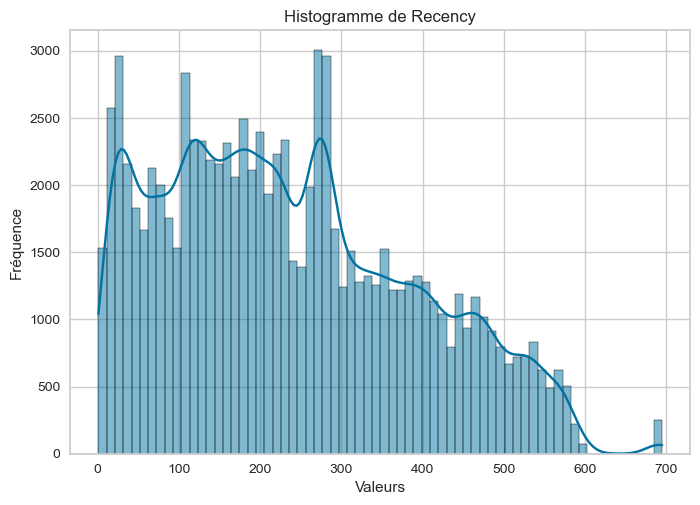

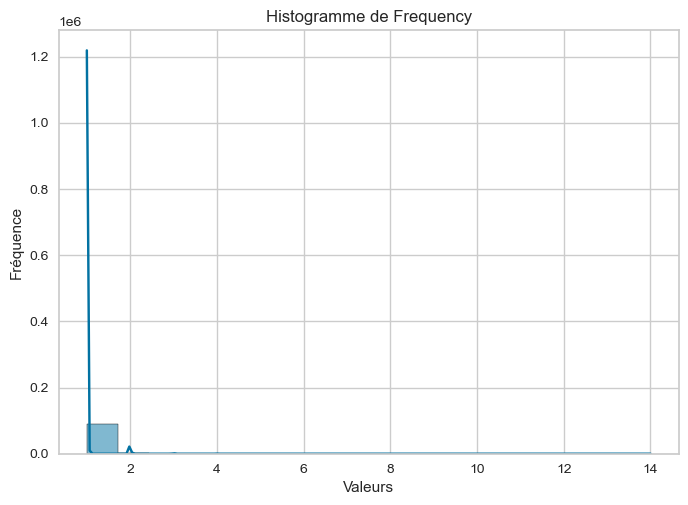

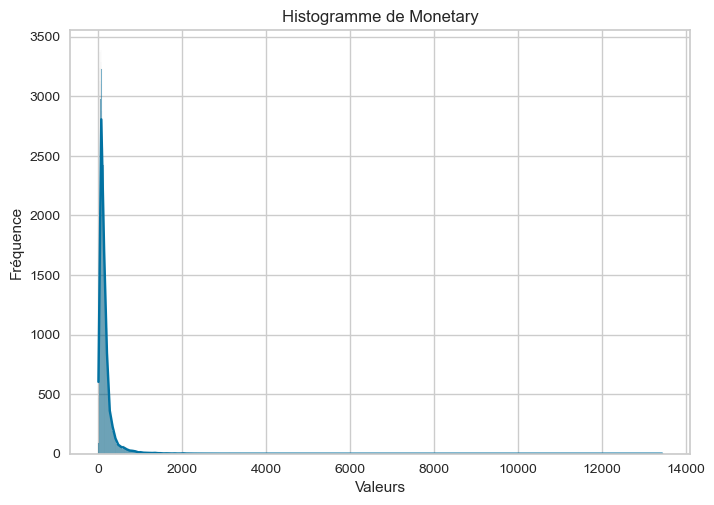

In [4]:
# Visualisation des données
data_col_num = ['Recency','Frequency','Monetary']

for col in data_col_num : 
    sns.histplot(x=data[col], kde=True)
    plt.title(f'Histogramme de {col}')
    plt.xlabel('Valeurs')
    plt.ylabel('Fréquence')
    plt.show()

## Pre-processing

In [5]:
# Sélection des variables 
num_cols = ['Recency','Frequency','Monetary']

In [6]:
data_RFM = data[num_cols]

In [7]:
# Transformateurs pour les colonnes
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# On applique les transformateurs aux colonnes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols)
    ])

# Pipeline complète avec le prétraitement
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# On applique la pipeline sur les données
transformed_data = pipeline.fit_transform(data_RFM)

In [8]:
display(data_RFM.head())
display(transformed_data)

,Recency,Frequency,Monetary
0,112,1,141.90
1,114,1,27.19
2,537,1,86.22
3,321,1,43.62
4,288,1,196.89


array([[-0.81683463, -0.15936018, -0.0891372 ],
       [-0.80372951, -0.15936018, -0.59634316],
       [ 1.96800338, -0.15936018, -0.33533394],
       ...,
       [ 2.17113274, -0.15936018, -0.21931019],
       [-0.77096671, -0.15936018, -0.12543884],
       [ 1.61416514, -0.15936018, -0.40015513]])

## K-means

**n_init** : est le nombre de fois où on execute k_means en positionnant les centroides au hasard. A chaque excution on regarde le SSE (la somme des erreurs quadratiques ou inertie (distance des points aux centroïdes)). Au final, K_means retourne la position des centroïdes pour laquel l'inertie est la plus faible donc la meilleure. 

In [9]:
# Test K-means simplement
kmeans = KMeans(n_init=10)

kmeans.fit(transformed_data)

# Obtenir les étiquettes de cluster pour chaque point de données
cluster_labels = kmeans.labels_

# Obtenir les centroïdes des clusters
centroids = kmeans.cluster_centers_

# Afficher les étiquettes de cluster
display(cluster_labels)

# Afficher les coordonnées des centroïdes
display(centroids)

array([0, 0, 4, ..., 4, 0, 4], dtype=int32)

array([[-0.99009795, -0.15936018, -0.22907194],
       [ 0.12699155, -0.15936018, -0.25629265],
       [-0.10237945,  4.69068165,  0.5225831 ],
       [ 0.11062928, -0.11316931,  4.05552231],
       [ 1.46135695, -0.15936018, -0.16978725],
       [-0.10055953,  0.14736183, 10.67928129],
       [-0.24382244, 11.44447821,  1.5635756 ],
       [-0.26628175, -0.15936018,  1.25131194]])

### Optimisation

#### Méthode du coude

C'est une méthode qui aide à déterminer le nombre de cluster optimal. Elle indique a partir de quel cluster en rajouter ne diminue pas la distance intra-clusters (souvent appelée somme des erreurs quadratiques ou SSE pour "Sum of Squared Errors").

Méthode : 
1. On choisis une plage de k (cluster) 
2. On applique l'algorithme pour chaque k 
3. On trace les SSE

**L'inertie** est la somme des distances au carré entre chaque point de données et le centroïde de son cluster.

/Users/laurachatard/anaconda3/lib/python3.11/site-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/Users/laurachatard/anaconda3/lib/python3.11/site-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


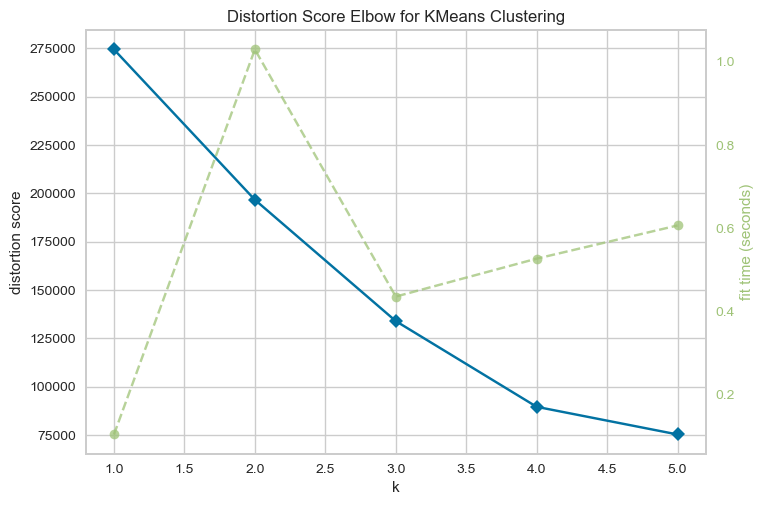

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
# Méthode du coude
kmeans = KMeans(n_init=10, random_state=42)
visualizer = KElbowVisualizer(kmeans, k=(1, 6))
visualizer.fit(transformed_data)
visualizer.show()

#### Silhouette

Elle évalue la qualité des clusters.

La mesure de silhouette varie de -1 à +1 :
- Une valeur proche de +1 indique que le point est bien placé dans son cluster, étant loin des autres clusters.
- Une valeur proche de 0 signifie que le point est sur la frontière de décision entre deux clusters voisins.
- Une valeur proche de -1 suggère que le point a été placé dans le mauvais cluster.

Pour calculer la silhouette d'un point spécifique, deux distances sont utilisées :

**La cohésion (a)** : La distance moyenne entre le point et tous les autres points dans le même cluster. Une petite valeur indique que le point est bien intégré dans son cluster.

**La séparation (b)** : La distance minimale moyenne entre le point et tous les points dans le cluster le plus proche dont le point n'est pas membre. Une grande valeur indique que le point est loin des autres clusters.

L'utilisation de la silhouette permet non seulement d'évaluer la pertinence du nombre de clusters choisi mais également de comparer l'efficacité de différents algorithmes de clustering ou différentes configurations de paramètres pour un même algorithme.

**La silouhette moyenne** est une mesure qui prend en compte la cohésion et la séparation de chaque échantillon et en fait la moyenne. Plus le résultat est proche de 1 plus le clustering est de bonne qualité (les points sont proches les uns des autres dans le même cluster et loin des autres clusters)

In [11]:
silhouette_scores = []
for k in range(2, 5):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(transformed_data)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(transformed_data, labels))

In [12]:
# Calculer la silhouette moyenne de tous les échantillons
silhouette_avg = silhouette_score(transformed_data, cluster_labels)
print("La silhouette moyenne est :", silhouette_avg)

# Calculer la silhouette de chaque échantillon
sample_silhouette_values = silhouette_samples(transformed_data, cluster_labels)
display(sample_silhouette_values)

La silhouette moyenne est : 0.44893213221906214


array([0.54540865, 0.47855266, 0.6160168 , ..., 0.5867628 , 0.51879398,
       0.62482467])

**COMMENTAIRE**

Le score de silhouette est de 0.45, on en conclu que les clusters ne sont pas de bonne qualité.

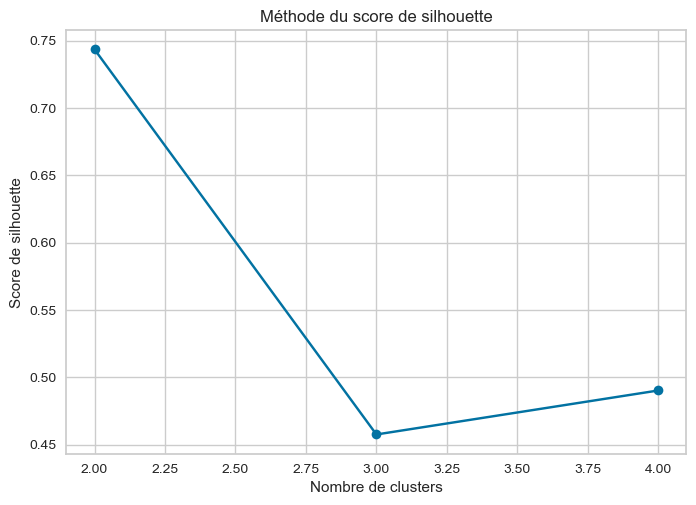

In [13]:
# Graphique du score de silhouette en fonction de k
plt.plot(range(2, 5), silhouette_scores, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de silhouette')
plt.title('Méthode du score de silhouette')
plt.show()

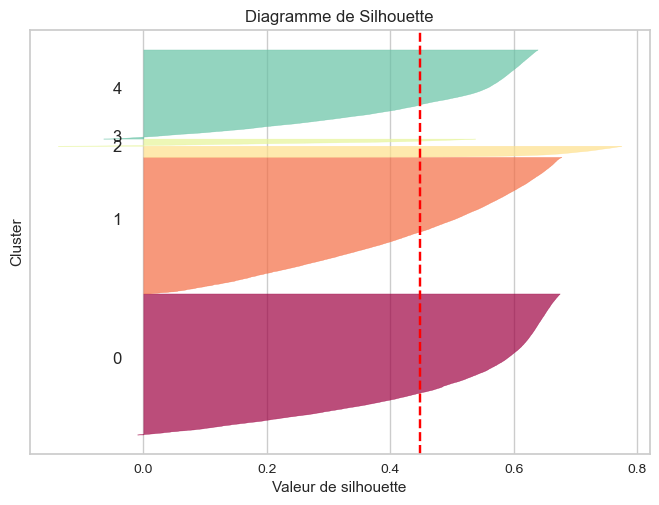

In [14]:
# Créer un diagramme de silhouette
fig, ax = plt.subplots()
y_lower = 10
for i in range(5):  # Pour chaque cluster
    # Sélectionner les valeurs de silhouette pour le cluster i
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    # Trier les valeurs de silhouette du cluster i
    ith_cluster_silhouette_values.sort()
    # Calculer la taille du cluster i
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    # Remplir la couleur pour le cluster i
    color = plt.colormaps["Spectral"](float(i) / 5)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    # Étiqueter chaque cluster avec son numéro
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    # Mettre à jour y_lower pour le prochain cluster
    y_lower = y_upper + 10

ax.set_title("Diagramme de Silhouette")
ax.set_xlabel("Valeur de silhouette")
ax.set_ylabel("Cluster")
ax.axvline(x=silhouette_avg, color="red", linestyle="--")  # Ligne pour la silhouette moyenne
ax.set_yticks([])  # Supprimer les étiquettes d'axe y
plt.show()

**INTERPRETATION**

Le diagramme de silouette nous indique que les clusters 0 et 1 ne pas bien défini car leur valeur avoisine les 0. 
Les clusters 2 à 4 sont quant à eux mieux définis. 

**La méthode du coude** nous indique un k=4.

**La méthode du score de silhouette** nous indique un k=2 optimal.

On gardera 4 pour la suite.

### K-means fonction

In [15]:
def K_means(data, n_clusters): 
    
    # Initialisation du modèle KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(transformed_df)
    
    # Récupérer les labels des clusters
    cluster_labels = kmeans.labels_
    
    # Ajouter les labels de cluster au DataFrame original
    data['Cluster'] = cluster_labels
    
    # Obtenir les centroïdes des clusters
    centroids = kmeans.cluster_centers_
    
    # Visualisation des clusters avec un pairplot
    sns.pairplot(data, hue='Cluster', palette='plasma')
    plt.title('Pairplot des clusters')
    plt.show()
    
    # Boxplot
    data_melt = pd.melt(data, id_vars='Cluster', var_name='Features', value_name='Values')
    
    g = sns.FacetGrid(data_melt, col='Features', sharey=False, col_wrap=3, palette='plasma', height=4)
    g.map(sns.boxplot, 'Cluster', 'Values', order=sorted(data['Cluster'].unique()))

    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle('Boxplot des clusters par feature', fontsize=16)
    plt.show()
    
    # Radarchart
    def create_radar_chart(data, cluster_labels, centroids):
        # Calcul des moyennes par cluster
        cluster_means = data.groupby('Cluster').mean()

        # Obtenir les caractéristiques et le nombre de variables (en excluant 'Cluster')
        features = cluster_means.columns.tolist()
        num_vars = len(features)

        # Calculer les angles pour le radar plot
        angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
        angles += angles[:1]  # Ajouter la première valeur à la fin pour fermer le cercle

        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

        # Tracer un radar plot pour chaque cluster
        for idx, row in cluster_means.iterrows():
            values = row.tolist()
            values += values[:1]  # Ajouter la première valeur à la fin pour fermer le cercle
            ax.plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {idx}')
            ax.fill(angles, values, alpha=0.25)

        # Ajouter des labels
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(features, fontsize=10)

        # Ajouter des labels de valeurs radiales
        ax.set_yticklabels([])

        # Afficher la légende et le titre
        plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
        plt.title('Radar Plot des Moyennes des Features par Cluster', fontsize=15)
        plt.show()
        
    create_radar_chart(data,cluster_labels,centroids)

In [16]:
display(data_RFM.head())

,Recency,Frequency,Monetary
0,112,1,141.90
1,114,1,27.19
2,537,1,86.22
3,321,1,43.62
4,288,1,196.89


,Recency,Frequency,Monetary
0,-0.816835,-0.15936,-0.089137
1,-0.803730,-0.15936,-0.596343
2,1.968003,-0.15936,-0.335334
3,0.552650,-0.15936,-0.523696
4,0.336416,-0.15936,0.154009
...,...,...,...
91481,1.378273,-0.15936,6.225402
91482,0.166049,-0.15936,-0.342585
91483,2.171133,-0.15936,-0.219310
91484,-0.770967,-0.15936,-0.125439


/Users/laurachatard/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/sg/93kbc44x3dz8s65w44mhwm100000gn/T/ipykernel_14139/1608847620.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cluster'] = cluster_labels


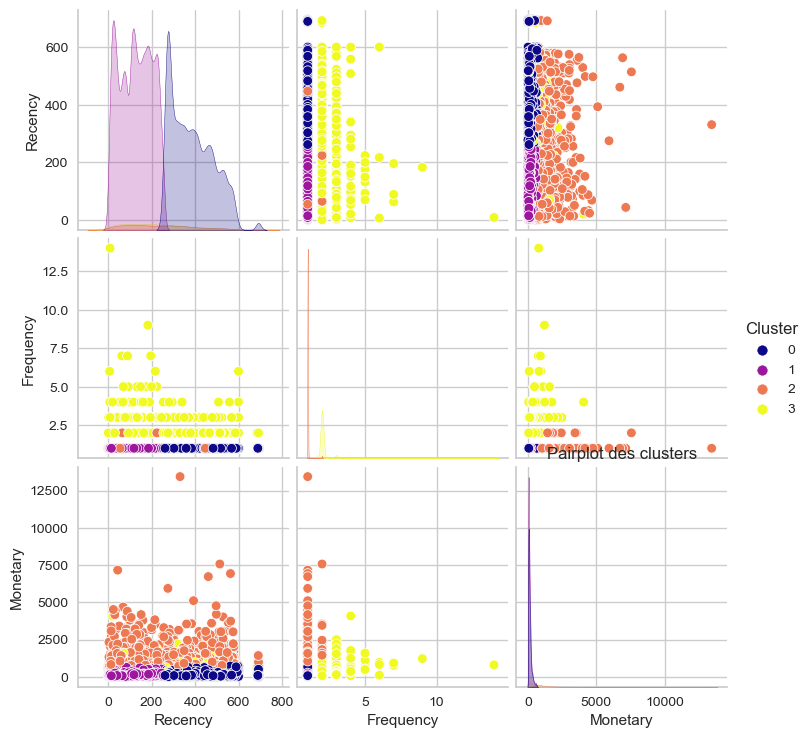

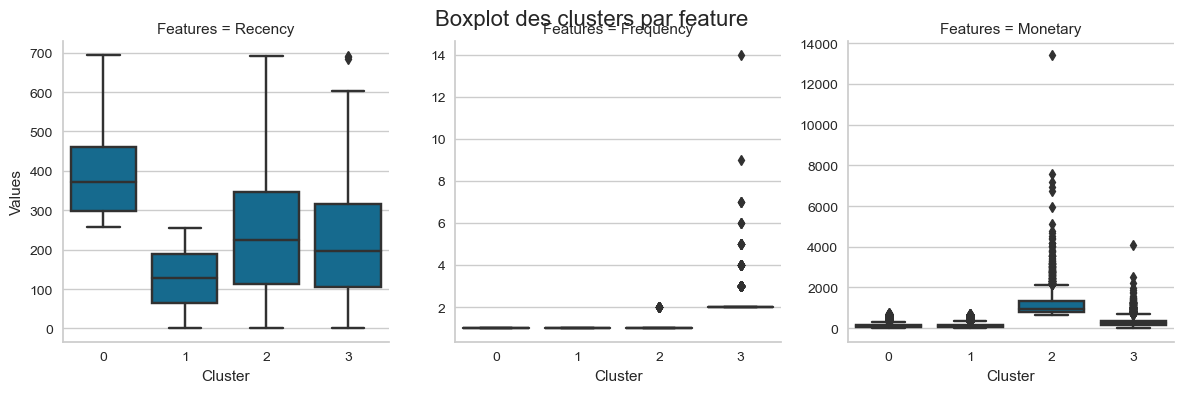

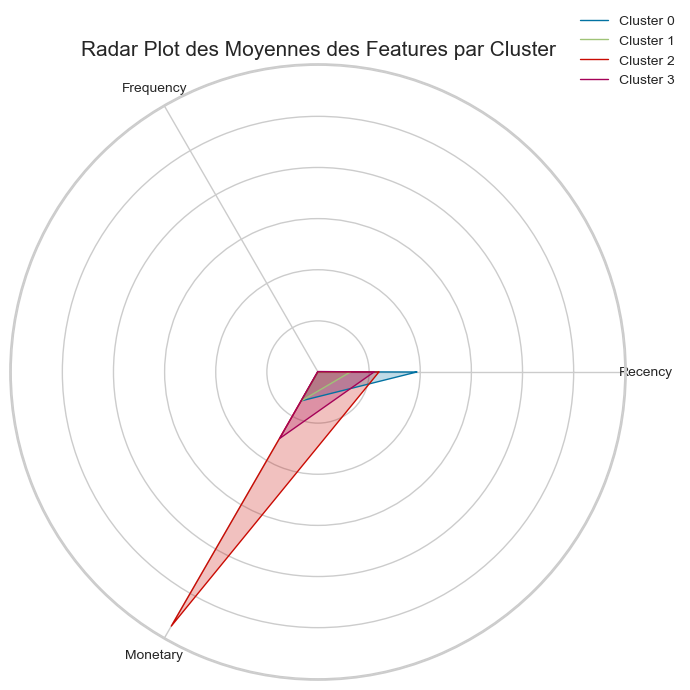

In [17]:
transformed_data = pipeline.fit_transform(data_RFM)
transformed_df = pd.DataFrame(transformed_data, columns=num_cols)
display(transformed_df)

# K-means optimisé
K_means(data_RFM,n_clusters=4)

In [18]:
display(data_RFM.head())

,Recency,Frequency,Monetary,Cluster
0,112,1,141.90,1
1,114,1,27.19,1
2,537,1,86.22,0
3,321,1,43.62,0
4,288,1,196.89,0


In [19]:
print(data_RFM['Cluster'].unique())

[1 0 3 2]


In [20]:
# Calcul de la moyenne des features par cluster
clustered_data = data_RFM.groupby('Cluster').mean(numeric_only=True)
print("Moyenne des features par cluster:")
print(clustered_data)
print('-----------------------------')

# Comptage des points dans chaque cluster
cluster_counts = data_RFM['Cluster'].value_counts()
print('Répartition dans les clusters :')
print(cluster_counts.to_dict())

Moyenne des features par cluster:
            Recency  Frequency     Monetary
Cluster                                    
0        386.351211   1.000000   130.330381
1        126.760500   1.000000   130.616162
2        238.196906   1.011706  1147.429628
3        219.234877   2.112024   300.479320
-----------------------------
Répartition dans les clusters :
{1: 49666, 0: 36750, 3: 2678, 2: 2392}


**Interprétation**

On remarque qu'il y a 2 clusters avec des dominantes de features : 
- le cluster 1 avec Frequency
- le cluster 2 avec Monetary



## CAH

L'algorithme de CAH (Classification Ascendante Hiérarchique), également connu sous le nom de clustering hiérarchique agglomératif, est une méthode de clustering utilisée pour regrouper des objets en fonction de leur similarité. Contrairement à KMeans, qui nécessite de spécifier le nombre de clusters à l'avance, la CAH construit une hiérarchie de clusters, permettant une exploration plus flexible des structures des données.

In [21]:
# Création d'un dataframe pour l'algorithme CAH
data_CAH = data[num_cols]

In [22]:
# Réduction du dataset
data_CAH_sample = data_CAH.sample(frac=0.004, random_state=42) #0,04%

print(data_CAH_sample.shape)

(366, 3)


In [23]:
# On applique la pipeline sur les données
transformed_data_CAH = pipeline.fit_transform(data_CAH_sample)

In [24]:
# Calcul des liaisons hiérarchiques
linked = linkage(transformed_data_CAH, method='average')

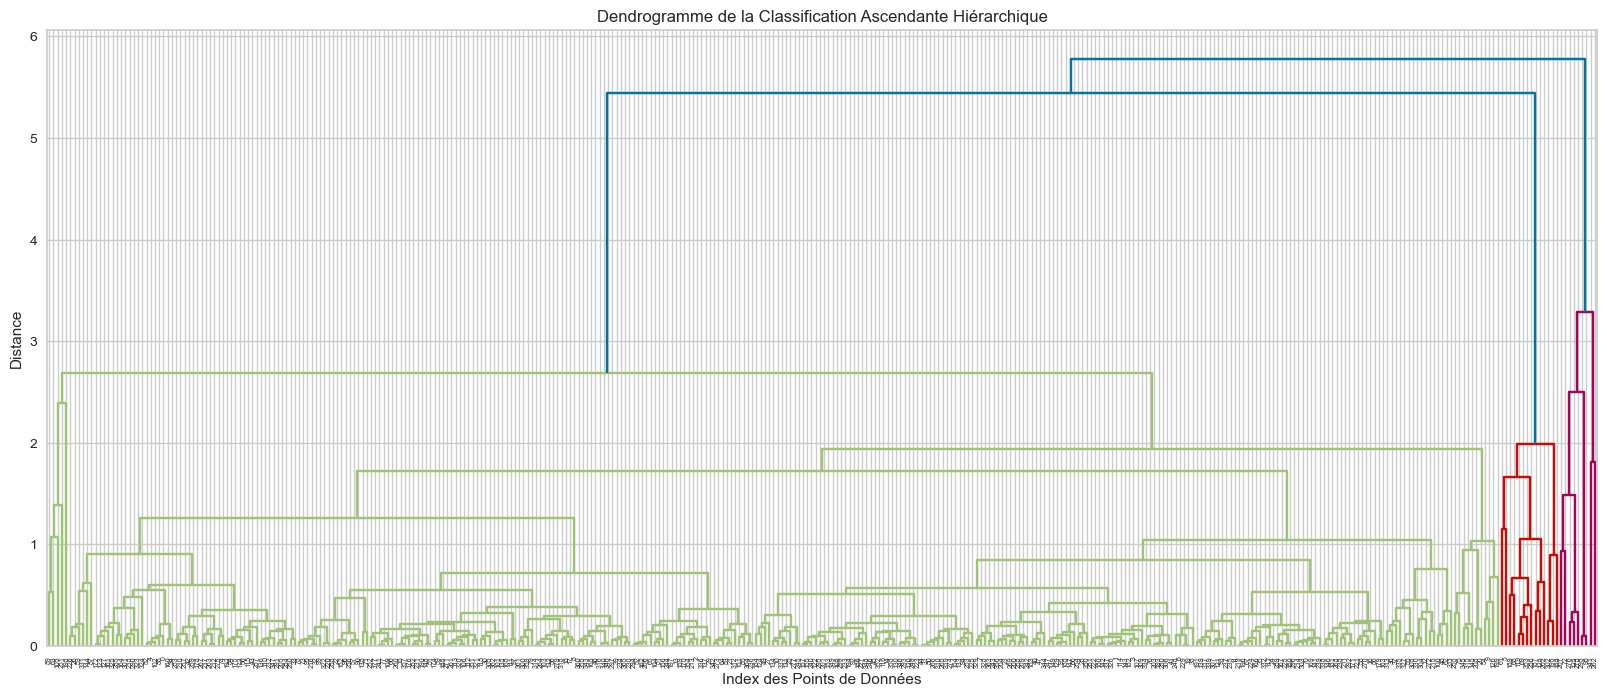

In [25]:
# Tracé du dendrogramme
plt.figure(figsize=(20, 8))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrogramme de la Classification Ascendante Hiérarchique')
plt.xlabel('Index des Points de Données')
plt.ylabel('Distance')
plt.xticks(rotation=90)
plt.show()

**Interprétation**

En prennant 0,04% du dataset, on obtient avec l'algorithme de CAH 3 clusters. 

## DBSCAN

In [26]:
# Création d'un dataframe pour l'algorithme DBSCAN
data_DBSCAN = data[num_cols]

In [27]:
# On applique la pipeline sur les données
transformed_data_DBSCAN = pipeline.fit_transform(data_DBSCAN)

In [28]:
# Fonction pour calculer la silhouette
def silhouette_scorer(estimator, X):
    estimator.fit(X)
    labels = estimator.labels_
    return silhouette_score(X, labels)

In [29]:
# Créer un estimateur DBSCAN
dbscan = DBSCAN()

# Définir la grille de recherche
param_grid = {'eps': [0.1, 0.5, 1.0],
              'min_samples': [5, 10, 20]}

# GridSearchCV avec la fonction de scoring silhouette
#grid_search = GridSearchCV(estimator=dbscan, param_grid=param_grid, scoring=silhouette_scorer)

# Exécuter la recherche par grille
#grid_search.fit(transformed_data_DBSCAN)

# Afficher les meilleurs paramètres et le meilleur score
#print("Meilleurs paramètres:", grid_search.best_params_)
#print("Meilleur score silhouette:", grid_search.best_score_)

In [30]:
# Créer une instance de DBSCAN
dbscan = DBSCAN(eps=1, min_samples=5)

# Ajuster le modèle aux données
dbscan.fit(transformed_data_DBSCAN)

# Obtenir les étiquettes des clusters (-1 indique du bruit)
labels = dbscan.labels_

/var/folders/sg/93kbc44x3dz8s65w44mhwm100000gn/T/ipykernel_14139/2706969230.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_DBSCAN['Cluster'] = cluster_labels


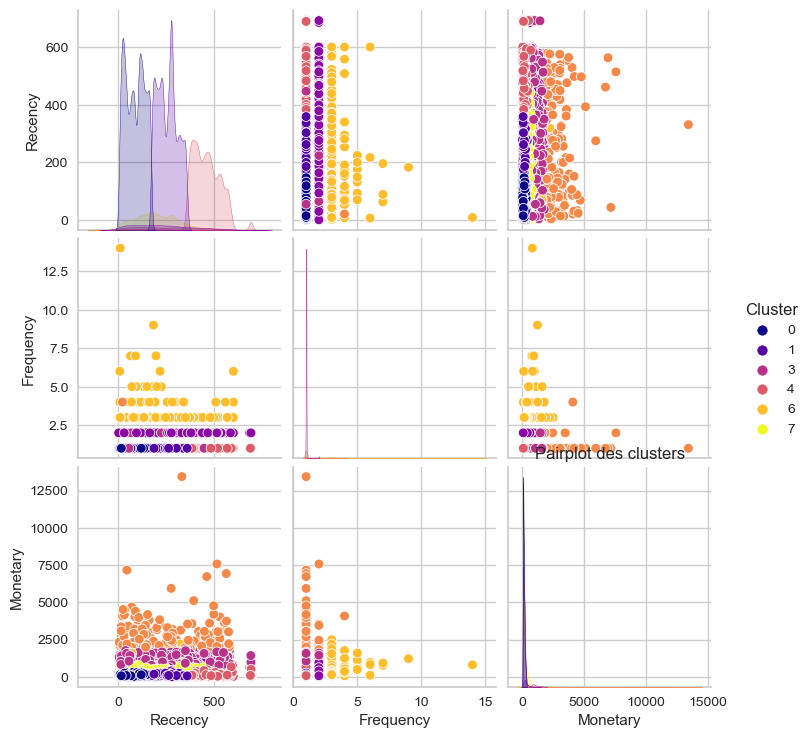

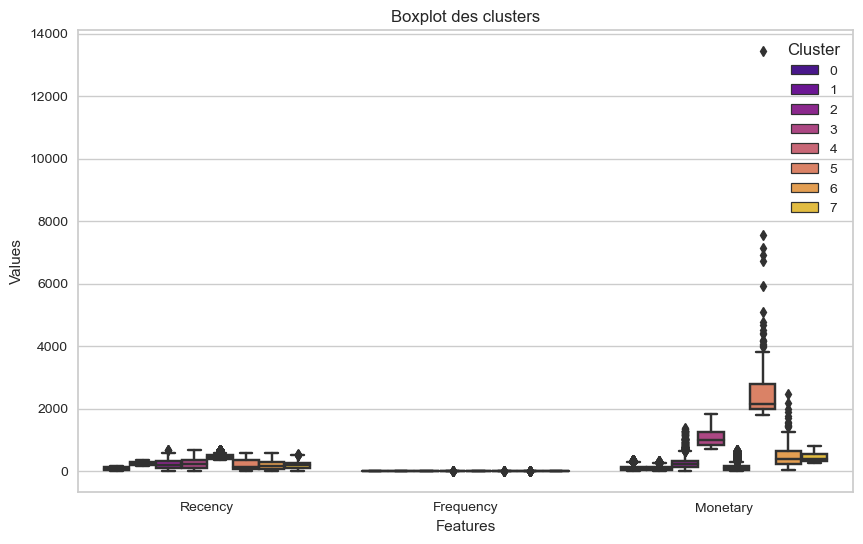

In [31]:
# Pairplot
data_DBSCAN['Cluster'] = cluster_labels
sns.pairplot(data_DBSCAN, hue='Cluster', palette='plasma')
plt.title('Pairplot des clusters')
plt.show()

# Boxplot
plt.figure(figsize=(10, 6))
data_DBSCAN_melt = pd.melt(data_DBSCAN, id_vars='Cluster', var_name='Features', value_name='Values')
sns.boxplot(x='Features', y='Values', hue='Cluster', data=data_DBSCAN_melt, palette='plasma')
plt.title('Boxplot des clusters')
plt.show()

## Synthèse

**CAH** : Il est possible de faire tourner l'algorithme que sur une petite partie du dataset du fait de son temps d'execution. Il n'est pas possible de faire des conclusions avec si peu de donnée. On ne retient pas cet algorithme.

**DBSCAN** : Ce modèle repose sur le principe de densité, or avec une variable comme 'Frequency' qui est discrète l'algorithme ne fournira pas des clusters pertinents.

**K-means** : K-means est l'algorithme que nous retiendrons pour la suite du projet car il est celui qui fourni des réponses les plus satisfaisantes en terme technique (temps et donnée) et en terme métier. 

# RFM + review score

In [35]:
# Visualisation des données
data_rs_col_num = ['Recency','Frequency','Monetary', 'Satisfaction']

data_RFM_RS = data[data_rs_col_num]
display(data_RFM_RS.head())
display(data_RFM.head())

,Recency,Frequency,Monetary,Satisfaction
0,112,1,141.90,5.0
1,114,1,27.19,4.0
2,537,1,86.22,3.0
3,321,1,43.62,4.0
4,288,1,196.89,5.0


,Recency,Frequency,Monetary,Cluster
0,112,1,141.90,1
1,114,1,27.19,1
2,537,1,86.22,0
3,321,1,43.62,0
4,288,1,196.89,0


## Pre-processing

In [36]:
# Transformateurs pour les colonnes
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# On applique les transformateurs aux colonnes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, data_rs_col_num)
    ])

# Pipeline complète avec le prétraitement
pipeline_rfm_rs = Pipeline(steps=[('preprocessor', preprocessor)])

# On applique la pipeline sur les données
transformed_data = pipeline_rfm_rs.fit_transform(data_RFM_RS)

In [40]:
# On applique la pipeline sur les données
transformed_data_rs = pipeline_rfm_rs.fit_transform(data_RFM_RS)

transformed_df_RS = pd.DataFrame(transformed_data_rs, columns=data_rs_col_num)

In [41]:
display(data_RFM_RS.head())
display(transformed_data_rs)
display(transformed_df_RS.head())

,Recency,Frequency,Monetary,Satisfaction
0,112,1,141.90,5.0
1,114,1,27.19,4.0
2,537,1,86.22,3.0
3,321,1,43.62,4.0
4,288,1,196.89,5.0


array([[-0.81683463, -0.15936018, -0.0891372 ,  0.66087889],
       [-0.80372951, -0.15936018, -0.59634316, -0.12076273],
       [ 1.96800338, -0.15936018, -0.33533394, -0.90240435],
       ...,
       [ 2.17113274, -0.15936018, -0.21931019,  0.66087889],
       [-0.77096671, -0.15936018, -0.12543884,  0.66087889],
       [ 1.61416514, -0.15936018, -0.40015513,  0.66087889]])

,Recency,Frequency,Monetary,Satisfaction
0,-0.816835,-0.15936,-0.089137,0.660879
1,-0.803730,-0.15936,-0.596343,-0.120763
2,1.968003,-0.15936,-0.335334,-0.902404
3,0.552650,-0.15936,-0.523696,-0.120763
4,0.336416,-0.15936,0.154009,0.660879


## K-means

In [42]:
# Choix du K optimal (méthode du coude)
inertia = []

for k in range(1, 6):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(transformed_data_rs)
    inertia.append(kmeans.inertia_)
    # Obtenir les étiquettes de cluster pour chaque point de données
    cluster_labels = kmeans.labels_
    # Obtenir les centroïdes des clusters
    centroids = kmeans.cluster_centers_

/Users/laurachatard/anaconda3/lib/python3.11/site-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/Users/laurachatard/anaconda3/lib/python3.11/site-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


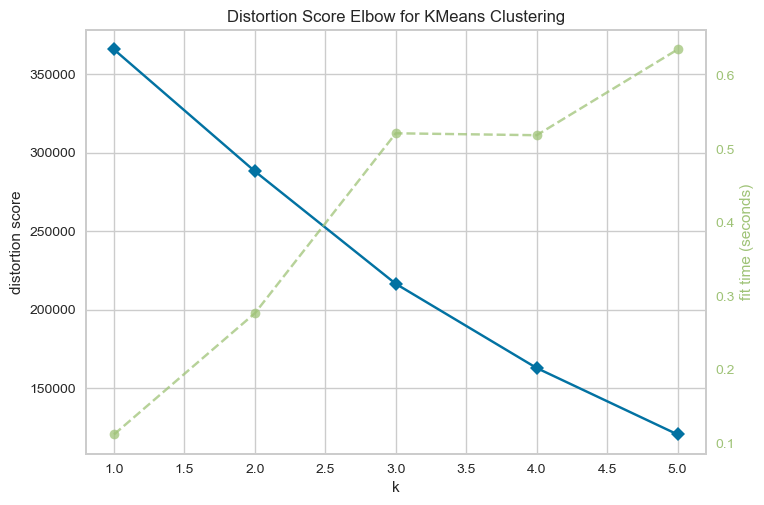

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [43]:
# Méthode du coude
kmeans = KMeans(n_init=10, random_state=42)
visualizer = KElbowVisualizer(kmeans, k=(1, 6))
visualizer.fit(transformed_data_rs)
visualizer.show()

In [44]:
# Silhouette
silhouette_scores = []
for k in range(2, 5):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(transformed_data_rs)
    inertia.append(kmeans.inertia_)
    # Obtenir les étiquettes de cluster pour chaque point de données
    cluster_labels = kmeans.labels_
    # Obtenir les centroïdes des clusters
    centroids = kmeans.cluster_centers_
    silhouette_scores.append(silhouette_score(transformed_data_rs, cluster_labels))

In [45]:
# Calculer la silhouette moyenne de tous les échantillons
silhouette_avg = silhouette_score(transformed_data_rs, cluster_labels)
print("La silhouette moyenne est :", silhouette_avg)

# Calculer la silhouette de chaque échantillon
sample_silhouette_values = silhouette_samples(transformed_data_rs, cluster_labels)
display(sample_silhouette_values)

La silhouette moyenne est : 0.3961819694073138


array([0.60349952, 0.498357  , 0.27533243, ..., 0.51937152, 0.59836378,
       0.55550172])

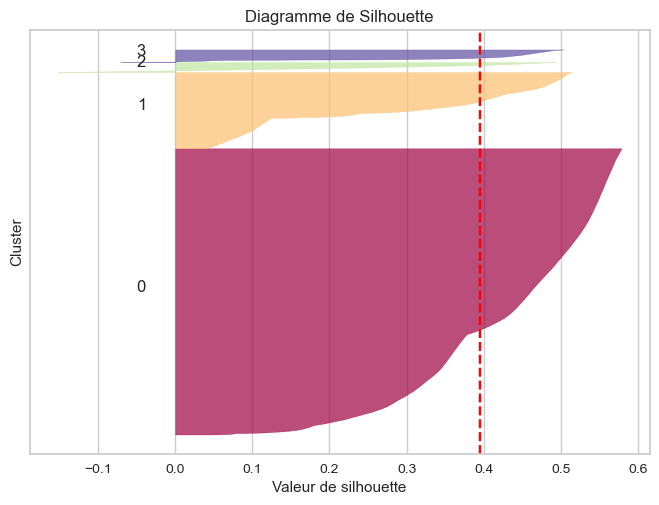

In [62]:
# Créer un diagramme de silhouette
fig, ax = plt.subplots()
y_lower = 10
for i in range(4):  # Pour chaque cluster
    # Sélectionner les valeurs de silhouette pour le cluster i
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    # Trier les valeurs de silhouette du cluster i
    ith_cluster_silhouette_values.sort()
    # Calculer la taille du cluster i
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    # Remplir la couleur pour le cluster i
    color = plt.colormaps["Spectral"](float(i) / 3)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    # Étiqueter chaque cluster avec son numéro
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    # Mettre à jour y_lower pour le prochain cluster
    y_lower = y_upper + 10

ax.set_title("Diagramme de Silhouette")
ax.set_xlabel("Valeur de silhouette")
ax.set_ylabel("Cluster")
ax.axvline(x=silhouette_avg, color="red", linestyle="--")  # Ligne pour la silhouette moyenne
ax.set_yticks([])  # Supprimer les étiquettes d'axe y
plt.show()

/Users/laurachatard/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


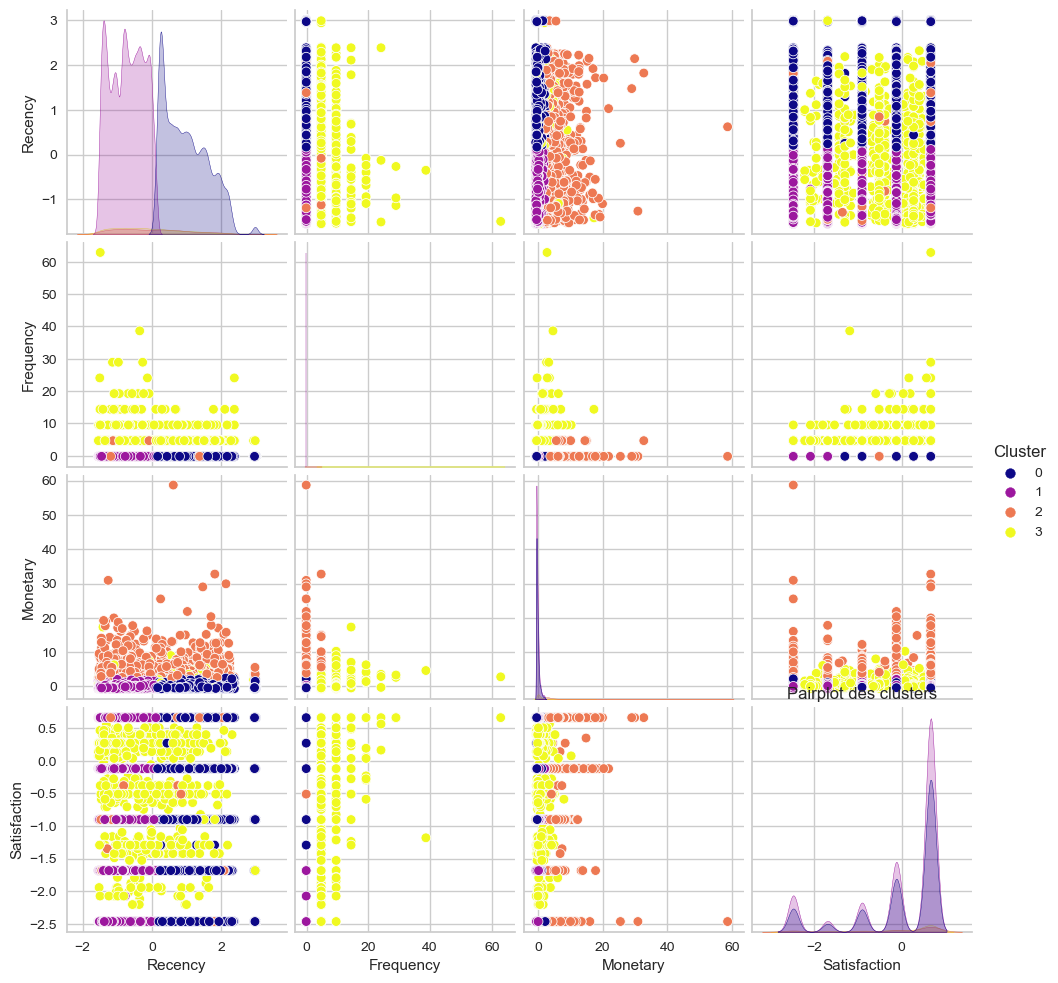

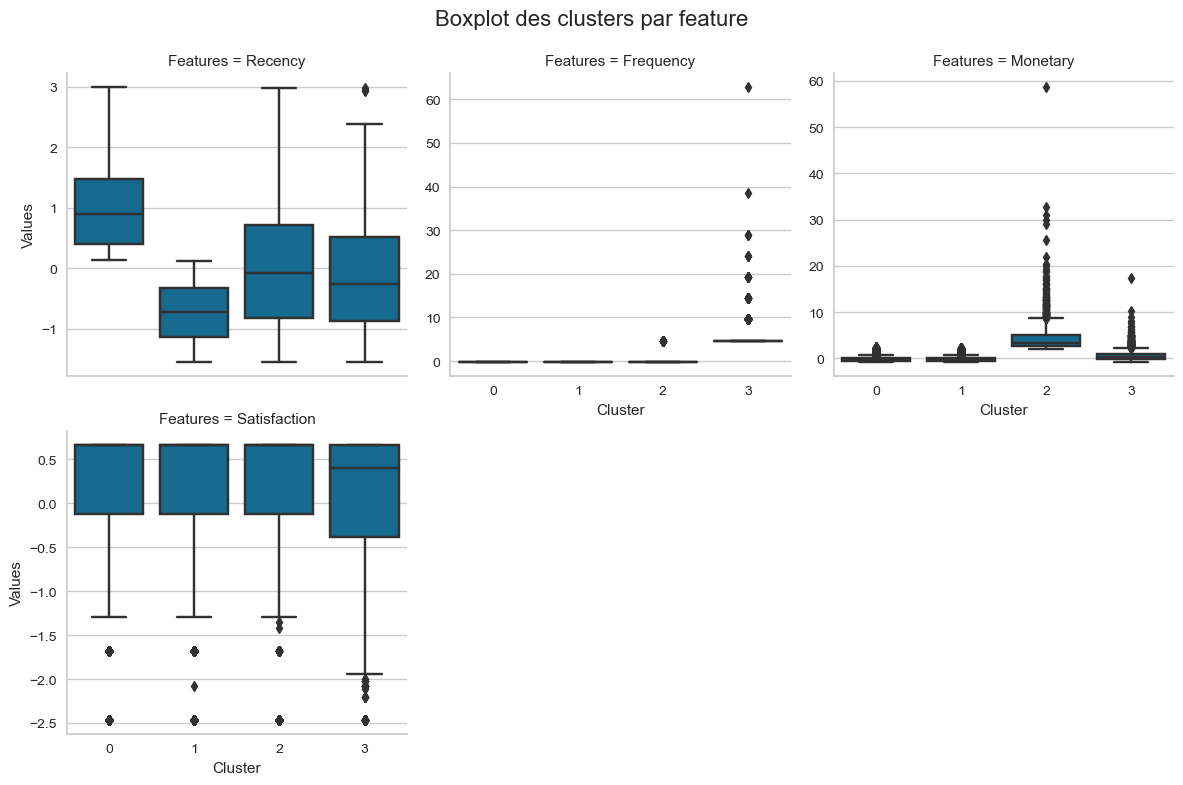

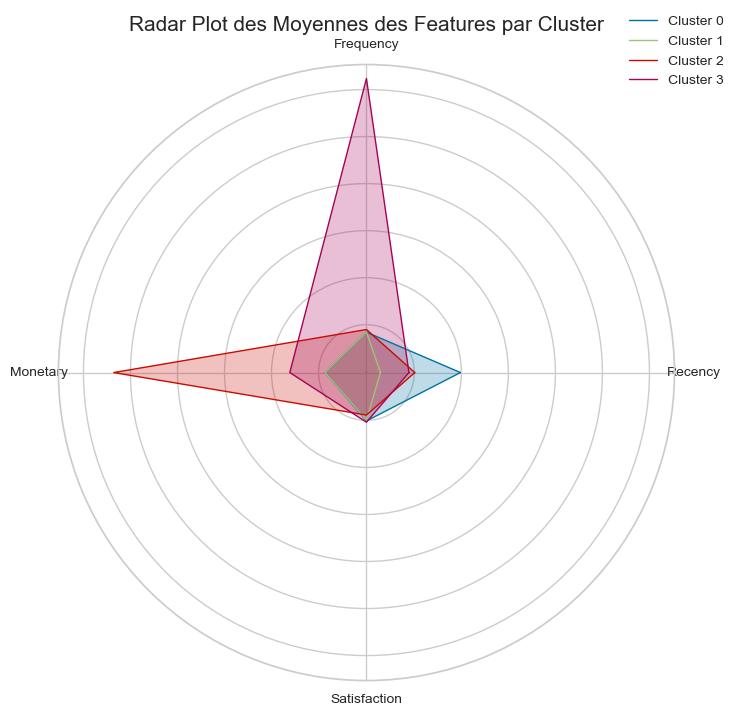

In [63]:
K_means(transformed_df_RS, n_clusters=4)

## Synthèse

La méthode du coude ne révèle pas de "cassure' au niveau des distances entre les clusters qui indiquerai un nombre de cluster optimal.
En revanche le score de la silhouette indique que 2 clusters sont de bonnes qualités. 

D'un point de vu marketing le rajout du review score ne semble pas pertinent car cela ne segmenterai les clients qu'en 4 clusters.

# RFM + features

In [48]:
# Import data RFM + features

data_customers = pd.read_csv('data_customers_unique.csv')

display(data_customers.head())

,customer_unique_id,Frequency,Monetary,qty_product,panier_moyen,payment_type_most,review_score_mean,category_most,qty_photos_mean,descricption_lenght_mean,order_status_most,Recency,customer_state,order_delivered_days_mean
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,1,141.90,credit_card,5.0,cama_mesa_banho,1.0,236.0,delivered,112,['SP'],6.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,1,27.19,credit_card,4.0,beleza_saude,1.0,635.0,delivered,114,['SP'],2.0
2,0000f46a3911fa3c0805444483337064,1,69.00,1,86.22,credit_card,3.0,papelaria,3.0,177.0,delivered,537,['SC'],25.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,1,43.62,credit_card,4.0,telefonia,5.0,1741.0,delivered,321,['PA'],20.0
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,1,196.89,credit_card,5.0,telefonia,3.0,794.0,delivered,288,['SP'],13.0


In [49]:
# Création d'un dataframe RFM_features
col_num = ['Recency', 'Frequency','Monetary','review_score_mean','panier_moyen','qty_product']

#col_cat = ['category_most']

data_RFM_features = data_customers[col_num]

In [50]:
display(data_RFM_features.head())

,Recency,Frequency,Monetary,review_score_mean,panier_moyen,qty_product
0,112,1,129.90,5.0,141.90,1
1,114,1,18.90,4.0,27.19,1
2,537,1,69.00,3.0,86.22,1
3,321,1,25.99,4.0,43.62,1
4,288,1,180.00,5.0,196.89,1


In [51]:
# Transformateurs pour les colonnes
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# On applique les transformateurs aux colonnes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, col_num),
        #('cat', categorical_transformer, col_cat)#
    ])

# Pipeline complète avec le prétraitement
pipeline_rfm_features = Pipeline(steps=[('preprocessor', preprocessor)])

# On applique la pipeline sur les données
transformed_data_customers = pipeline_rfm_features.fit_transform(data_RFM_features)

In [52]:
print(transformed_data_customers)

[[-0.81683463 -0.15936018 -0.07572268  0.66087889 -0.06323119 -0.21641176]
 [-0.80372951 -0.15936018 -0.53102752 -0.12076273 -0.59669617 -0.21641176]
 [ 1.96800338 -0.15936018 -0.32552506 -0.90240435 -0.32217401 -0.21641176]
 ...
 [ 2.17113274 -0.15936018 -0.2397965   0.66087889 -0.20014348 -0.21641176]
 [-0.77096671 -0.15936018 -0.13684018  0.66087889 -0.10141224 -0.21641176]
 [ 1.61416514 -0.15936018 -0.37478823  0.66087889 -0.39035112 -0.21641176]]


In [53]:
# Choix du K optimal (méthode du coude)
inertia = []

for k in range(1, 6):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(transformed_data_customers)
    inertia.append(kmeans.inertia_)

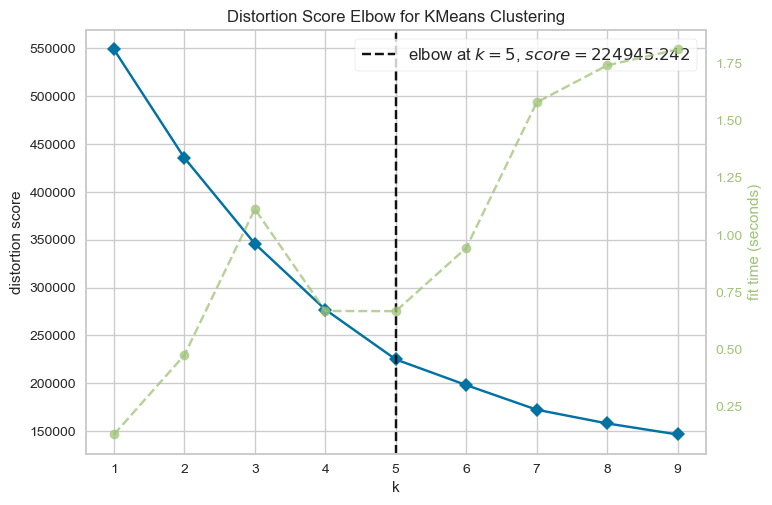

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [54]:
# Méthode du coude
kmeans = KMeans(n_init=10, random_state=42)
visualizer = KElbowVisualizer(kmeans, k=(1, 10))
visualizer.fit(transformed_data_customers)
visualizer.show()

In [55]:
# Silhouette
silhouette_scores = []
for k in range(2, 5):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(transformed_data_customers)
    cluster_labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(transformed_data_customers, cluster_labels))

In [56]:
# Calculer la silhouette moyenne de tous les échantillons
silhouette_avg = silhouette_score(transformed_data_customers, cluster_labels)
print("La silhouette moyenne est :", silhouette_avg)

# Calculer la silhouette de chaque échantillon
sample_silhouette_values = silhouette_samples(transformed_data_customers, cluster_labels)
display(sample_silhouette_values)

La silhouette moyenne est : 0.39481621266364686


array([0.5360828 , 0.32895402, 0.05325226, ..., 0.32167974, 0.54387281,
       0.39903736])

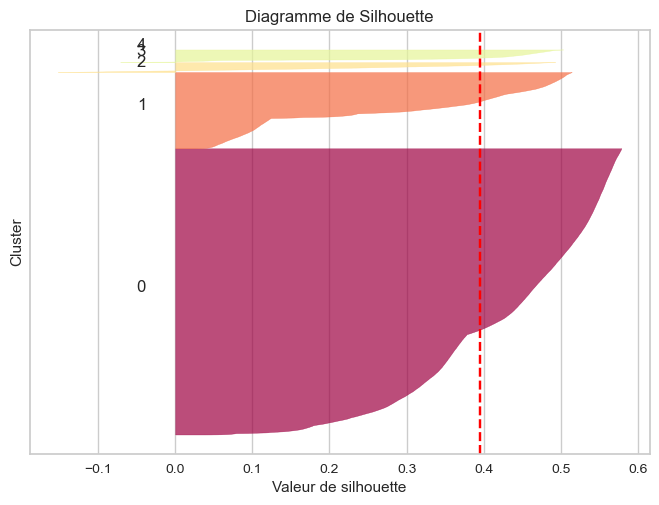

In [57]:
# Créer un diagramme de silhouette
fig, ax = plt.subplots()
y_lower = 10
for i in range(5):  # Pour chaque cluster
    # Sélectionner les valeurs de silhouette pour le cluster i
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    # Trier les valeurs de silhouette du cluster i
    ith_cluster_silhouette_values.sort()
    # Calculer la taille du cluster i
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    # Remplir la couleur pour le cluster i
    color = plt.colormaps["Spectral"](float(i) / 5)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    # Étiqueter chaque cluster avec son numéro
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    # Mettre à jour y_lower pour le prochain cluster
    y_lower = y_upper + 10

ax.set_title("Diagramme de Silhouette")
ax.set_xlabel("Valeur de silhouette")
ax.set_ylabel("Cluster")
ax.axvline(x=silhouette_avg, color="red", linestyle="--")  # Ligne pour la silhouette moyenne
ax.set_yticks([])  # Supprimer les étiquettes d'axe y
plt.show()

In [58]:
transformed_data_customers_df = pd.DataFrame(transformed_data_customers, columns=(
    col_num #+ list(pipeline.named_steps['preprocessor'].named_transformers_['cat']
                   #['encoder'].get_feature_names_out(col_cat)# )
))
display(transformed_data_customers_df.head())

,Recency,Frequency,Monetary,review_score_mean,panier_moyen,qty_product
0,-0.816835,-0.15936,-0.075723,0.660879,-0.063231,-0.216412
1,-0.803730,-0.15936,-0.531028,-0.120763,-0.596696,-0.216412
2,1.968003,-0.15936,-0.325525,-0.902404,-0.322174,-0.216412
3,0.552650,-0.15936,-0.501945,-0.120763,-0.520288,-0.216412
4,0.336416,-0.15936,0.129780,0.660879,0.192503,-0.216412


/Users/laurachatard/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


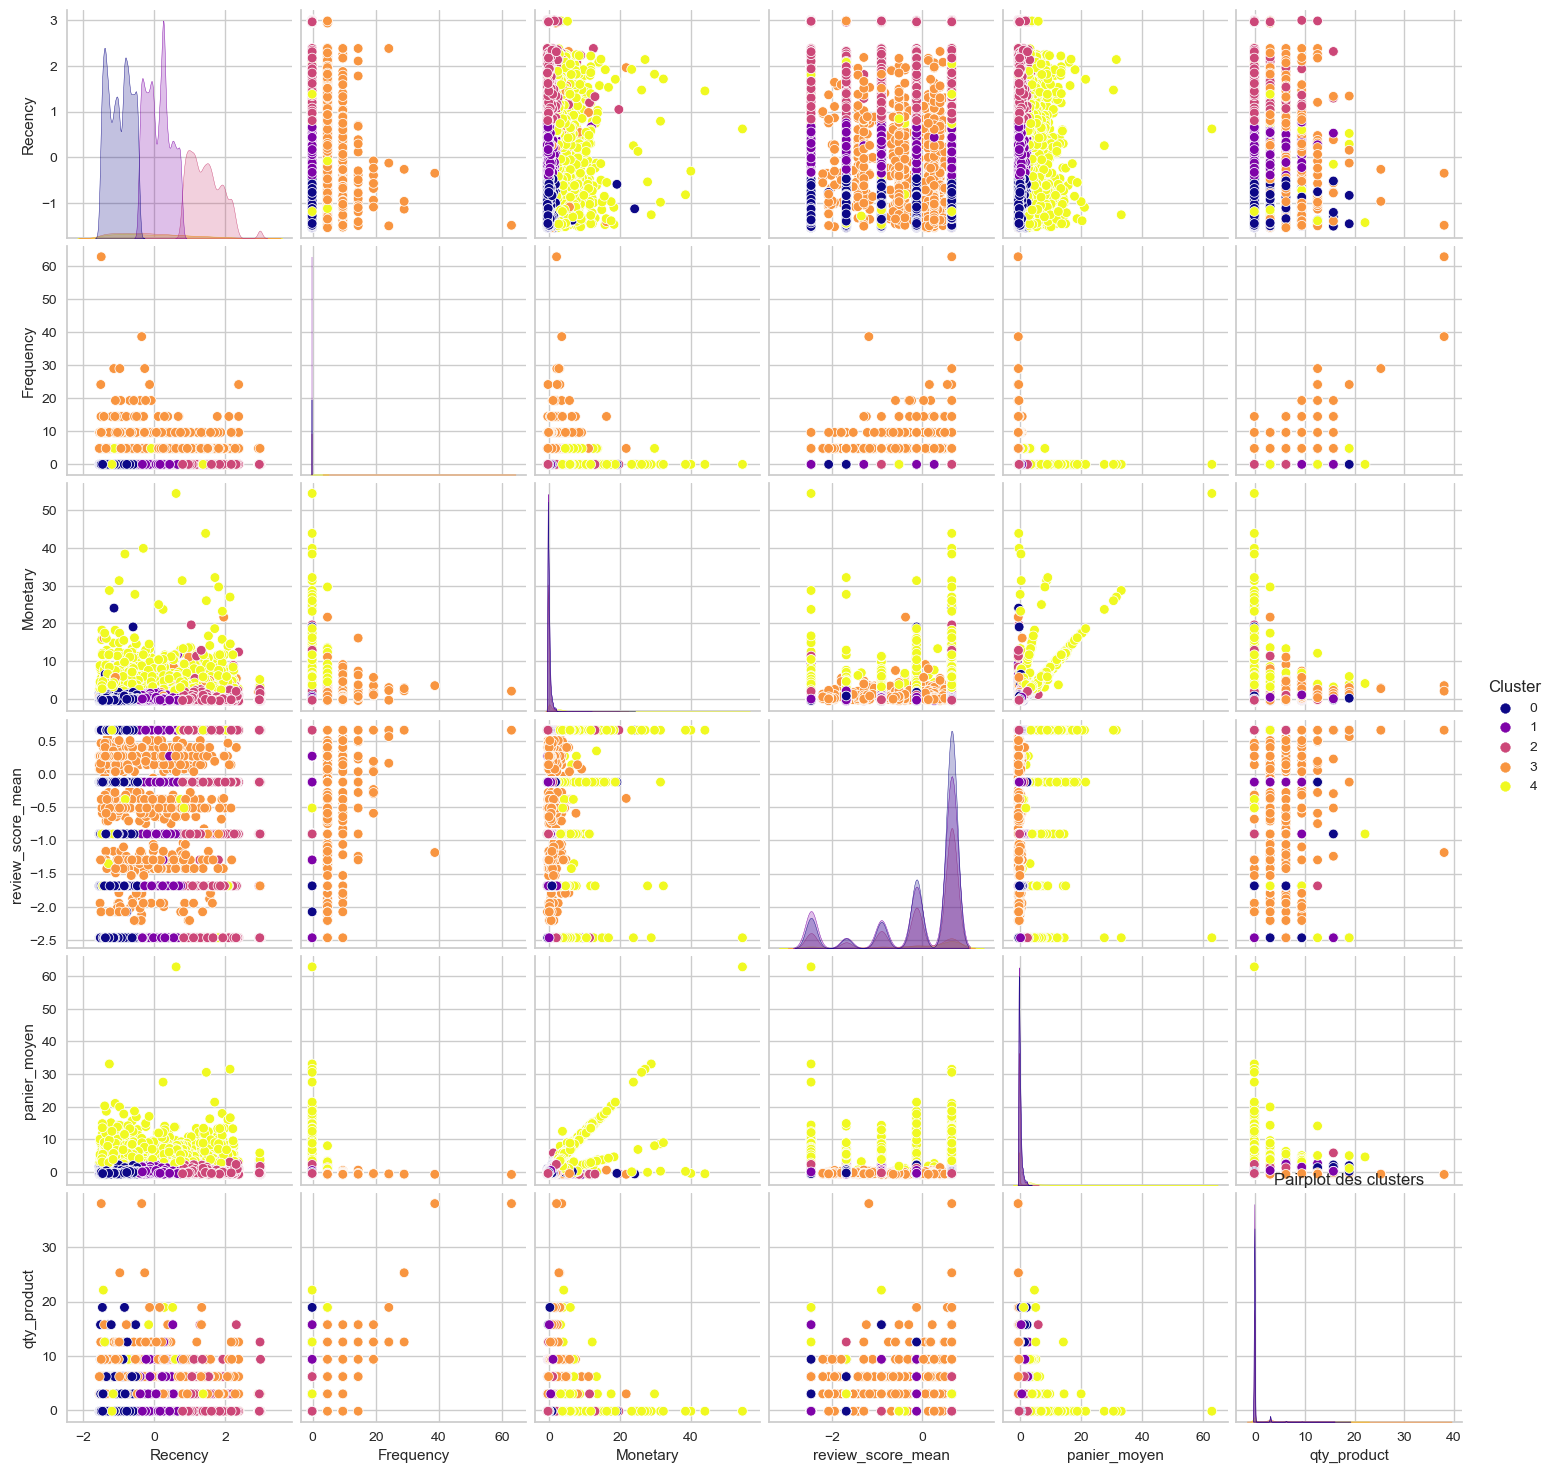

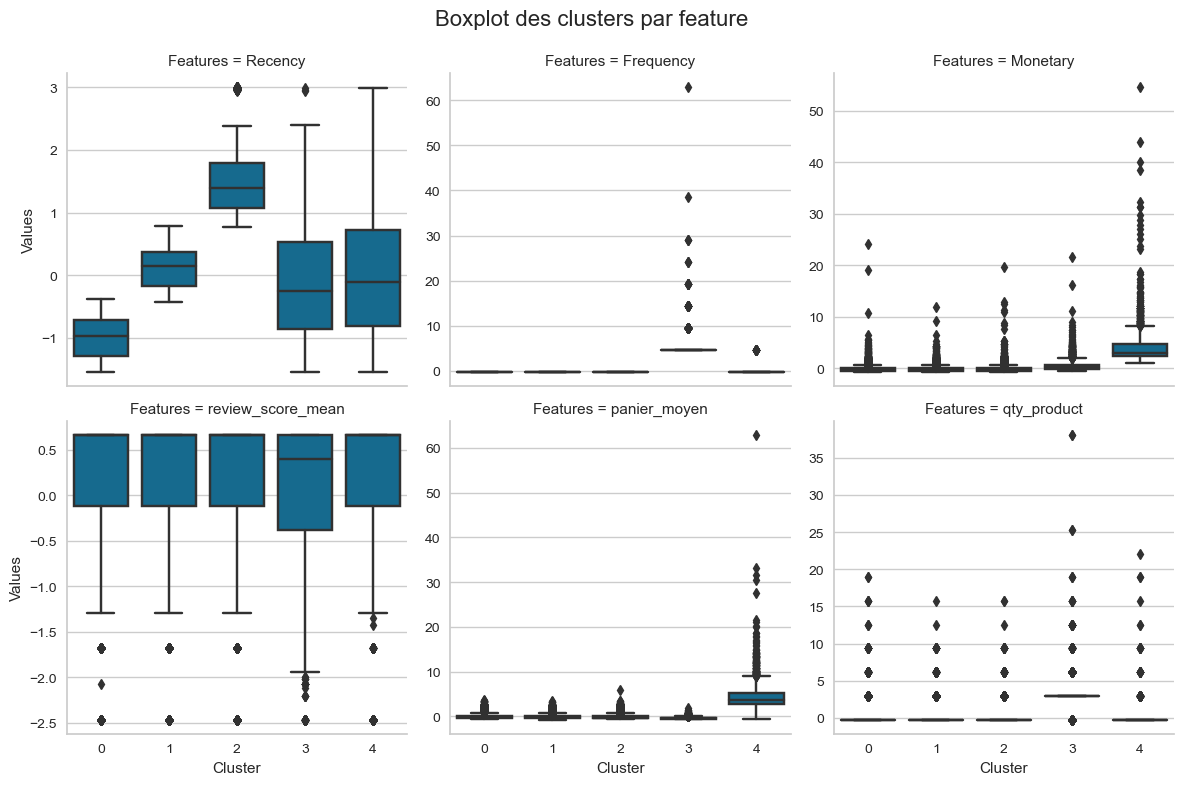

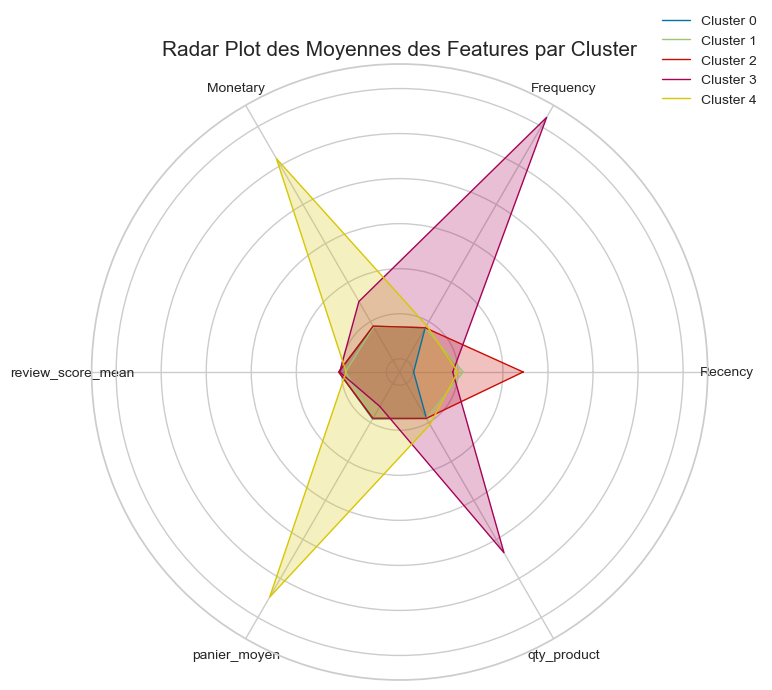

In [59]:
K_means(transformed_data_customers_df, n_clusters=5)

In [60]:
transformed_data_customers_df['Cluster'].unique()

array([0, 2, 1, 3, 4], dtype=int32)

## Synthèse

Parmi les 5 clusters on peut segmenter : 

- Cluster 0 : Clients qui ne sont venus depuis longtemps
- Cluster 1 : Clients équilibrés / moyen
- Cluster 2 : Clients nouveaux
- Cluster 3 : Clients qui achètent le plus souvent et en grande quantité
- Cluster 4 : Clients dépensiers 